In [3]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), 'Oracle_Assignment_2'))

In [ ]:
from Oracle_Assignment_2 import q2_get_mnist_jpg_subset

input_data_2 = q2_get_mnist_jpg_subset(23475)


Downloaded ZIP file to ./q2_data.zip
<zipfile.ZipFile filename='./q2_data.zip' mode='r'>
Extracted ZIP contents to q2_data


In [1]:
import torch
from torchvision import transforms, datasets

mlp_transforms = transforms.Compose([
transforms.Grayscale(),
transforms.Resize((28,28)),
transforms.ToTensor(),
transforms.Lambda(torch.flatten)
])

mlp_dataset = datasets.ImageFolder('/home/uditchirag/Desktop/AI ML/Assignment 2/q2_data',transform = mlp_transforms)


In [91]:
from torch.utils.data import DataLoader, random_split

def prepare_data_loaders(dataset, batch_size=32, train_split=0.8, seed=34):
  
    
    total_samples = len(dataset)
    train_size = int(train_split * total_samples)
    test_size = total_samples - train_size

    
    torch.manual_seed(seed)
    train_data, test_data = random_split(dataset, [train_size, test_size])
    

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [92]:

mlp_train_loader, mlp_test_loader = prepare_data_loaders(mlp_dataset, batch_size=32, train_split=0.8, seed=34)


In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.first_layer = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.second_layer = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.third_layer = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        x = self.first_layer(x)
        x = self.relu1(x)
        x = self.second_layer(x)
        x = self.relu2(x)
        x = self.third_layer(x)
        return x 
    

In [445]:
import torch.optim as optim


input_size = 784  
hidden_size1 = 256
hidden_size2 = 128
num_classes = 10 
batch_size = 32
learning_rate = 0.001
num_epochs = 10


mlp_model = MLP(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)


In [452]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        
        for images, labels in train_loader:

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0) 
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    return model


In [453]:

trained_mlp_model = train_model(mlp_model, mlp_train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 0.0057
Epoch [2/10], Loss: 0.0036
Epoch [3/10], Loss: 0.0018
Epoch [4/10], Loss: 0.0009
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


In [454]:
def evaluate(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    all_predictions = []
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            all_labels.append(labels)
            logits = model(images)
            probabilities = F.softmax(logits, dim=1)
            all_probabilities.append(probabilities)

            predicted = torch.argmax(logits, dim=1)
            all_predictions.append(predicted)
            for i in range(len(labels)):
                actual_label = labels[i].item()
                predicted_label = predicted[i].item()
                if predicted_label == actual_label:
                    correct += 1  
                total += 1  

    probabilities_array = torch.cat(all_probabilities, dim=0)
    predictions_array = torch.cat(all_predictions, dim=0)
    labels_array = torch.cat(all_labels, dim=0)
    accuracy = 100*correct / total

    return probabilities_array, predictions_array, labels_array, accuracy

In [457]:
mlp_results = evaluate(trained_mlp_model, mlp_test_loader)
mlp_probabilities, mlp_predictions, mlp_labels, mlp_accuracy = mlp_results

print(mlp_probabilities[0])
print(mlp_predictions[0])
print(mlp_labels[0])
print(mlp_accuracy)

tensor([8.8304e-13, 5.2392e-15, 2.6326e-10, 2.0417e-16, 1.0000e+00, 2.2657e-12,
        2.3627e-11, 5.7636e-15, 1.0272e-11, 6.2706e-11])
tensor(4)
tensor(4)
95.6


In [462]:
cnn_dataset = datasets.ImageFolder('/home/uditchirag/Desktop/AI ML/Assignment 2/q2_data',transform = transforms.Compose([
transforms.Grayscale(),
transforms.Resize((28,28)),
transforms.ToTensor()
]))


In [463]:
cnn_train_loader, cnn_test_loader = prepare_data_loaders(cnn_dataset, batch_size=32, train_split=0.8, seed=34)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)         
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)         
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [464]:
model_cnn = CNN(num_classes=10)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
num_epochs_cnn = 10

trained_cnn_model = train_model(model_cnn, cnn_train_loader, criterion_cnn, optimizer_cnn, num_epochs_cnn)

Epoch [1/10], Loss: 0.5120
Epoch [2/10], Loss: 0.1269
Epoch [3/10], Loss: 0.0811
Epoch [4/10], Loss: 0.0561
Epoch [5/10], Loss: 0.0450
Epoch [6/10], Loss: 0.0299
Epoch [7/10], Loss: 0.0182
Epoch [8/10], Loss: 0.0139
Epoch [9/10], Loss: 0.0157
Epoch [10/10], Loss: 0.0142


In [468]:
evaluate(model_cnn, cnn_test_loader)
cnn_probilities, cnn_predictions, cnn_labels, cnn_accuracy = evaluate(model_cnn, cnn_test_loader)
print(cnn_accuracy)
print(cnn_probilities[0])
print(cnn_labels[0])
print(cnn_predictions[0])

97.95
tensor([3.6376e-12, 1.9150e-09, 2.4694e-11, 1.1511e-18, 1.0000e+00, 7.3788e-16,
        2.3644e-15, 4.7276e-10, 1.0969e-09, 7.1039e-13])
tensor(4)
tensor(4)


In [470]:



metric_cnn = evaluate_multiclass(cnn_labels, cnn_predictions, cnn_probilities)

Overall Accuracy: 0.9795



RuntimeError: Boolean value of Tensor with more than one value is ambiguous

# Q 2 (3)


In [36]:
import numpy as np


from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)) ])


dataset = datasets.ImageFolder('/home/uditchirag/Desktop/AI ML/Assignment 2/q2_data',transform = transform)

new_dataset_raw = []

for i in range(len(dataset)):
    new_dataset_raw.append(dataset[i][0])
new_dataset = np.array(new_dataset_raw)
print(new_dataset.shape)


(10000, 784)


In [392]:
dataset_mean = np.mean(new_dataset, axis=0)
dataset_centre = new_dataset - dataset_mean
dataset_cov = (dataset_centre.T @ dataset_centre) / ((dataset_centre.shape[0])-1)

eigenvalues, eigenvectors = np.linalg.eigh(dataset_cov)

idices = np.argsort(eigenvalues)[: : -1]
eigenvalues_desc = eigenvalues[idices]
eigenvectors_desc = eigenvectors[:, idices]

num_features= 400
principal_comp = eigenvectors_desc[:, :num_features]
print(principal_comp.shape)

X_pca = dataset_centre @ principal_comp


(784, 400)


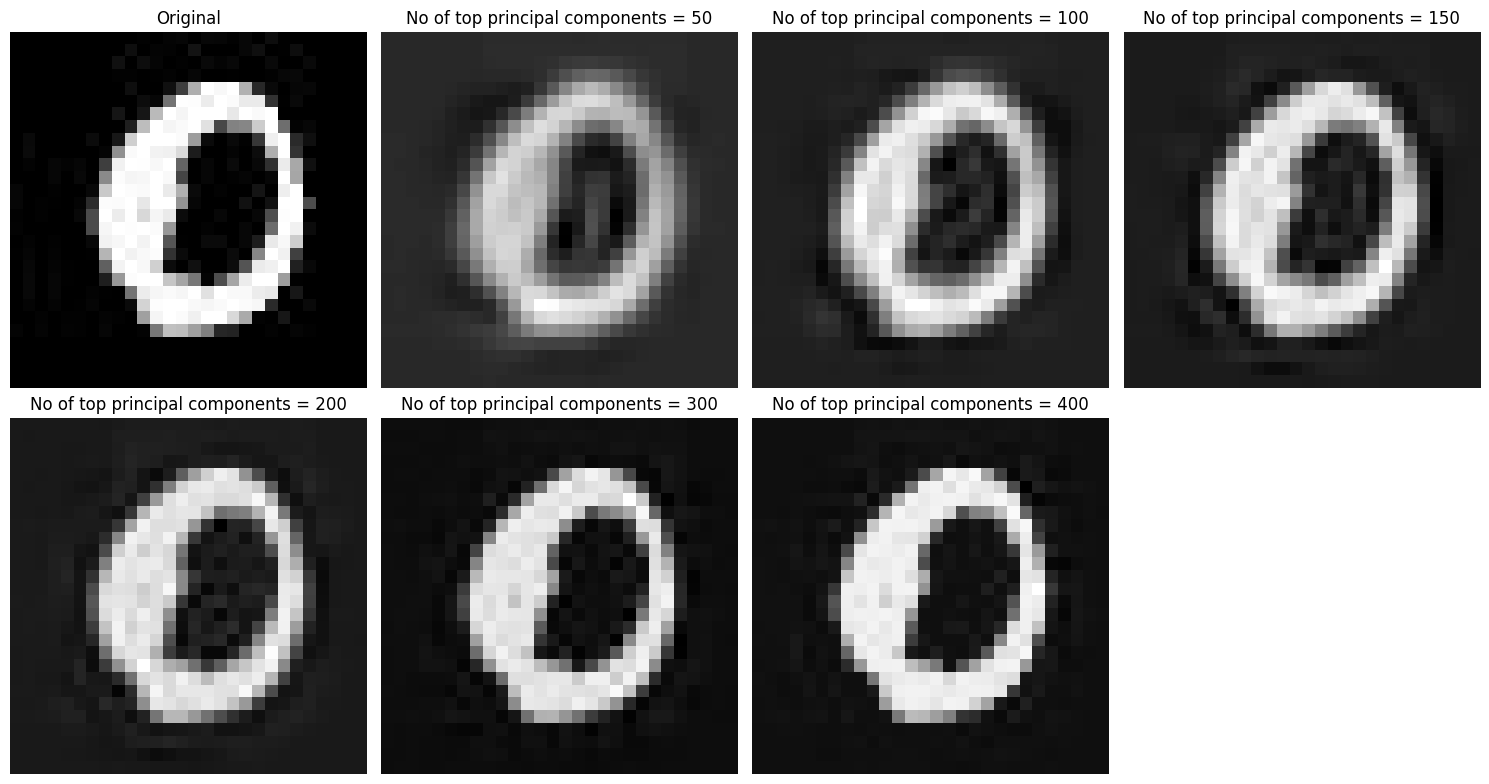

In [478]:



original_img = new_dataset[5].reshape(28, 28)
img_centered = new_dataset[5] - dataset_mean

ks = [50, 100, 150, 200, 300, 400]

plt.figure(figsize=(15, 8))
plt.subplot(2, 4, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis("off")

for i, k in enumerate(ks):
    principal_comp_k = eigenvectors_desc[:, :k]
    projection = np.dot(img_centered, principal_comp_k)
    reconstructed_img = np.dot(projection, principal_comp_k.T) + dataset_mean
    reconstructed_img = reconstructed_img.reshape(28, 28)
    plt.subplot(2, 4, i + 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f"No of top principal components = {k}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [393]:
print(X_pca.shape)

(10000, 400)


In [394]:
import matplotlib.pyplot as plt

(10000, 784)


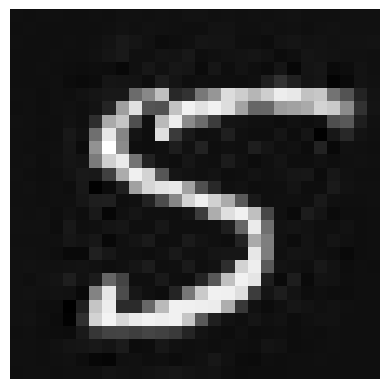

<class 'type'>


In [397]:

X_reconstructed = np.dot(X_pca, principal_comp.T) + dataset_mean

print(X_reconstructed.shape)


img = X_reconstructed[5400]
img = img.reshape(28, 28) 
plt.imshow(img, cmap='gray')
plt.axis("off")  # Hide axis for better visualization
plt.show()
print(type)

## Q 2(4)

In [422]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, datasets

label = []
for sample in dataset.samples:
    label.append(sample[1])
labels = np.array(label)


num_samples = X_pca.shape[0]
indices = np.arange(num_samples)
np.random.seed(34)
np.random.shuffle(indices)
split = int(0.8 * num_samples)
train_idx, test_idx = indices[:split], indices[split:]

X_train_pca, X_test_pca = X_pca[train_idx], X_pca[test_idx]
y_train_pca, y_test_pca = labels[train_idx], labels[test_idx]


X_tensor_pca = torch.tensor(X_pca, dtype=torch.float32)
y_tensor_pca = torch.tensor(labels, dtype=torch.long)


pca_dataset = TensorDataset(X_tensor_pca, y_tensor_pca)

batch_size = 32

pca_mlp_train_loader, pca_mlp_test_loader = prepare_data_loaders(pca_dataset, batch_size=batch_size, train_split=0.8, seed=34)


In [48]:
class PCA_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes):
        super(PCA_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [444]:

model_pca_mlp = PCA_MLP(num_features, 128, 64, 10)
criterion_pca_mlp = nn.CrossEntropyLoss()
optimizer_pca_mlp = optim.Adam(model_pca_mlp.parameters(), lr=0.001)
num_epochs_pca_mlp = 10


In [442]:
model_pca_mlp = train_model(model_pca_mlp, pca_mlp_train_loader, criterion_pca_mlp, optimizer_pca_mlp, num_epochs_pca_mlp)

Epoch [1/10], Loss: 0.4819
Epoch [2/10], Loss: 0.1832
Epoch [3/10], Loss: 0.1122
Epoch [4/10], Loss: 0.0648
Epoch [5/10], Loss: 0.0341
Epoch [6/10], Loss: 0.0170
Epoch [7/10], Loss: 0.0076
Epoch [8/10], Loss: 0.0035
Epoch [9/10], Loss: 0.0024
Epoch [10/10], Loss: 0.0027


In [443]:
mlp_pca_results = evaluate(model_pca_mlp, pca_mlp_test_loader)
mlp_pca_probabilities, mlp_pca_predictions, mlp_pca_labels, mlp_pca_accuracy = mlp_pca_results  
print(mlp_pca_accuracy)

93.2


## Q 2(5)


In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def max_likelihood_grad_des_w_b(eta, iter, x, y):

    n,d = x.shape
    w = np.zeros(d)
    b = 0
    for _ in range(iter):
        sum1 = np.zeros(d)
        sum2 = 0
        for j in range(n):
            p = np.dot(w,x[j]) + b  
            z = sigmoid(p)
            q = y[j] - z
            sum1 += q*x[j] 
            sum2 += q
        w = w + eta*sum1
        b = b + eta*sum2
    return w,b


def class_label_extractor(y_train,class_name):
    y_class = []
    for j in y_train:
        if j == class_name:
            y_class.append(1)
        else:
            y_class.append(0)
    y_class_array = np.array(y_class)
    return y_class_array


def train_class_classifier(X_train,y_train,class_name, eta, iter):
    y_class = class_label_extractor(y_train,class_name)
    w, b = max_likelihood_grad_des_w_b(eta, iter, X_train, y_class)
    return w, b


def class_classifier_predict(X_test, w, b,t):
    y_pred = []
    for i in range(len(X_test)):
        p = np.dot(w,X_test[i]) + b
        z = sigmoid(p)
        if z > t:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred_array = np.array(y_pred)
    return y_pred_array

def precision(class_name,y_pred,y_true):
    tp = 0
    fp = 0
    for i in range(len(y_pred)):
        if y_pred[i] == class_name and y_true[i] == class_name:
            tp += 1
        elif y_pred[i] == class_name and y_true[i] != class_name:
            fp += 1
  
    if tp + fp == 0:
        return 0
    return tp/(tp+fp)

def recall(class_name,y_pred,y_true):
    tp = 0
    fn = 0
    for i in range(len(y_pred)):
        if y_pred[i] == class_name and y_true[i] == class_name:
            tp += 1
        elif y_pred[i] != class_name and y_true[i] == class_name:
            fn += 1

    if tp + fn == 0:
        return 0
    return tp/(tp+fn)

def accuracy_score(y_pred,y_true):
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            correct += 1
    return correct/len(y_pred)


def f_1_score(class_name,y_pred,y_true):
    p = precision(class_name,y_pred,y_true)
    r = recall(class_name,y_pred,y_true)
    hm = 2*p*r/(p+r)
    return hm

def FPR(y_pred,y_true):
    fp = 0
    tn = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y_true[i] == 0:
            fp += 1
        elif y_pred[i] == 0 and y_true[i] == 0:
            tn += 1
    return fp/(fp+tn)


def confusion_matrix(y_true, y_pred):
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
        elif y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
    return [[tn, fp],
            [fn, tp]]


In [ ]:
def compute_auc(y_true, scores, num_thresholds=100):

    thresholds = np.linspace(0, 1, num_thresholds)
    tpr_list = []
    fpr_list = []
    
    for t in thresholds:
        
        y_pred = [1 if score >= t else 0 for score in scores]
        
        tp = sum(1 for yt, yp in zip(y_true, y_pred) if yt == 1 and yp == 1)
        fn = sum(1 for yt, yp in zip(y_true, y_pred) if yt == 1 and yp == 0)
        fp = sum(1 for yt, yp in zip(y_true, y_pred) if yt == 0 and yp == 1)
        tn = sum(1 for yt, yp in zip(y_true, y_pred) if yt == 0 and yp == 0)
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    sorted_indices = np.argsort(fpr_list)
    sorted_fpr = np.array(fpr_list)[sorted_indices]
    sorted_tpr = np.array(tpr_list)[sorted_indices]
    auc = np.trapz(sorted_tpr, sorted_fpr)
    
    return auc,sorted_fpr,sorted_tpr

In [486]:
from sklearn.metrics import roc_curve, auc

def evaluate_binary_classifiers(X_train, y_train, X_test, y_test, class_names, eta, n_iter, threshold=0.5):
    auc_scores = []
    weights, biases = {}, {}
    plt.figure(figsize=(10, 7))
    
    for cls in class_names:
        w, b = train_class_classifier(X_train, y_train, cls, eta, n_iter)
        weights[cls] = w
        biases[cls] = b
        
        # Compute scores for each test example
        scores = [sigmoid(np.dot(w, x) + b) for x in X_test]
        
        # Convert true labels to binary for current class
        y_test_bin = class_label_extractor(y_test, cls)
        
        # Use scikit-learn to compute ROC and AUC
        fpr, tpr, roc_thresholds = roc_curve(y_test_bin, scores)
        auc_value = auc(fpr, tpr)
        auc_scores.append(auc_value)
        
        # Get binary predictions based on threshold
        y_pred = class_classifier_predict(X_test, w, b, threshold)
        
        # Compute evaluation metrics
        prec = precision_binary(y_pred, y_test_bin)
        rec = recall_binary(y_pred, y_test_bin)
        acc = accuracy_score(y_pred, y_test_bin)
        fpr_val = fpr_binary(y_pred, y_test_bin)
        
        print(f"Class {cls}:")
        print(f"   AUC:       {auc_value:.4f}")
        print(f"   Precision: {prec:.4f}")
        print(f"   Recall:    {rec:.4f}")
        print(f"   Accuracy:  {acc:.4f}")
        print(f"   FPR:       {fpr_val:.4f}\n")
        
        plt.plot(fpr, tpr, label=f'Class {cls} (AUC={auc_value:.2f})')
    
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curves for Each Class")
    plt.legend()
    plt.show()
    
    avg_auc = np.mean(auc_scores)
    print(f"\nAverage AUC across all classes: {avg_auc:.4f}")
    
    return weights, biases


Class 0:
   AUC:       0.9943
   Precision: 0.9055
   Recall:    0.9579
   Accuracy:  0.9865
   FPR:       0.0105

Class 1:
   AUC:       0.9954
   Precision: 0.9400
   Recall:    0.9447
   Accuracy:  0.9885
   FPR:       0.0067

Class 2:
   AUC:       0.9696
   Precision: 0.7692
   Recall:    0.8824
   Accuracy:  0.9610
   FPR:       0.0301

Class 3:
   AUC:       0.9697
   Precision: 0.6312
   Recall:    0.8856
   Accuracy:  0.9365
   FPR:       0.0578

Class 4:
   AUC:       0.9851
   Precision: 0.8361
   Recall:    0.8644
   Accuracy:  0.9730
   FPR:       0.0165

Class 5:
   AUC:       0.9206
   Precision: 0.7736
   Recall:    0.6059
   Accuracy:  0.9420
   FPR:       0.0200

Class 6:
   AUC:       0.9937
   Precision: 0.8779
   Recall:    0.9303
   Accuracy:  0.9800
   FPR:       0.0145

Class 7:
   AUC:       0.9909
   Precision: 0.8622
   Recall:    0.9108
   Accuracy:  0.9750
   FPR:       0.0173

Class 8:
   AUC:       0.9573
   Precision: 0.8208
   Recall:    0.6762
   Accur

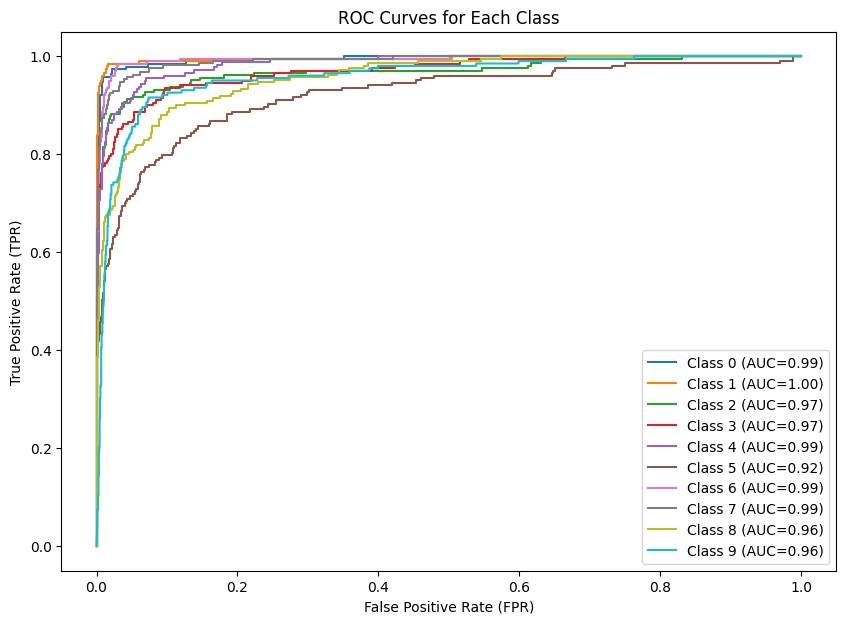


Average AUC across all classes: 0.9735


({0: array([-4.42571910e+00, -3.08203452e-01, -1.60759249e+00,  4.26577417e-01,
         -3.66006717e+00, -6.16632008e-01, -1.34632441e+00, -1.49913756e-01,
          2.45672364e-02, -7.02952979e-01, -1.93095846e+00,  3.33522604e+00,
          1.99411553e+00, -1.82374827e+00, -1.84378765e+00, -1.59572633e+00,
          3.97830006e-01, -2.48813198e+00, -2.44418442e+00, -8.50437778e-01,
         -1.45833385e+00, -1.12301538e-01, -8.33983032e-01,  5.64331170e-01,
          2.02066399e+00,  5.54115115e-01,  7.30997572e-01, -1.31257471e+00,
          3.56314040e+00,  3.11625257e-03, -1.11494323e+00, -1.33035686e+00,
         -1.12557125e+00,  1.19332605e+00, -6.10037619e-01, -1.63738996e+00,
          1.64709989e+00, -7.40878577e-01, -2.36618477e+00, -9.20519796e-01,
         -3.68187140e+00,  7.72275628e-01,  1.06250408e+00,  4.13655852e-01,
         -1.68989086e+00, -1.25256096e+00, -4.69058276e-01,  9.41940834e-01,
         -1.66282724e+00, -1.14132315e+00, -2.66045150e+00, -2.19733970e-

In [485]:
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
eta = 0.01         
n_iter = 1000      
threshold = 0.5    

evaluate_binary_classifiers(X_train_pca, y_train_pca, X_test_pca, y_test_pca, class_names, eta, n_iter, threshold)
    

In [ ]:

def confusion_matrix_multi(y_true, y_pred, n_classes):
    # Create an n_classes x n_classes matrix filled with zeros
    cm = [[0 for _ in range(n_classes)] for _ in range(n_classes)]
    
    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        cm[true_label][pred_label] += 1  # Increment corresponding cell
    
    return cm

import seaborn as sns
def evaluate_multiclass(y_true, y_pred, class_names):
    """
    Computes overall accuracy and per-class precision, recall, and F1 score using custom functions.
    Also computes and displays a confusion matrix.

    Args:
        y_true (list): True class labels.
        y_pred (list): Predicted class labels.
        class_names (list): List of class names (or numbers) e.g. [0,1,...,9].
    """
    # Overall accuracy using your custom function
    overall_acc = accuracy_score(y_pred, y_true)
    print(f"Overall Accuracy: {overall_acc:.4f}\n")
    
    n_classes = len(class_names)
  
    # Compute confusion matrix
    cm = confusion_matrix_multi(y_true, y_pred, n_classes)

    for c in class_names:
        p = precision(c, y_pred, y_true)
        r = recall(c, y_pred, y_true)
        f1 = f_1_score(c, y_pred, y_true) if (p + 
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    return overall_acc, cm

In [ ]:
mlp_pca_eval = evaluate_multiclass(mlp_pca_labels, mlp_pca_predictions, class_names)

In [ ]:
mlp_eval = evaluate_multiclass(mlp_labels, mlp_predictions, class_names)

In [ ]:
cnn_eval = evaluate_multiclass(cnn_labels, cnn_predictions, class_names)

In [ ]:
_results = evaluate(model_pca_mlp, pca_mlp_test_loader)
mlp_pca_probabilities, mlp_pca_predictions, mlp_pca_labels, mlp_pca_accuracy = mlp_pca_results
print(mlp_pca_probabilities[5])
print(mlp_pca_predictions[5])
print(mlp_pca_labels[5])

tensor([0.0921, 0.0913, 0.1139, 0.1076, 0.0959, 0.1058, 0.1099, 0.0967, 0.0892,
        0.0976])
tensor(2)
tensor(2)


In [ ]:
import numpy as np

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def train_multiclass_logistic_regression(X, y, eta, n_iter, n_classes):
    n, m = X.shape  
    W = np.zeros((m, n_classes)) 
    b = np.zeros(n_classes)  

    y_onehot = np.zeros((n, n_classes))
    y_onehot[np.arange(n), y] = 1 
    for _ in range(n_iter):
        
        scores = np.dot(X, W) + b 
        
        probabilities = softmax(scores)

        
        error = y_onehot - probabilities  
        grad_W = np.dot(X.T, error) / n 
        grad_b = np.sum(error, axis=0) / n  

       
        W += eta * grad_W
        b += eta * grad_b
    
    return W, b

def predict_multiclass_logistic_regression(X, W, b):
    scores = np.dot(X, W) + b 
    probabilities = softmax(scores)  
    return np.argmax(probabilities, axis=1) 

In [479]:
eta = 0.1
n_iter = 1000
n_classes = 10  


W_multi, b_multi = train_multiclass_logistic_regression(X_train_pca, y_train_pca, eta, n_iter, n_classes)


y_pred_multi = predict_multiclass_logistic_regression(X_test_pca, W_multi, b_multi)



Overall Accuracy: 0.8980

Class 0:
   Precision: 0.9158
   Recall:    0.9737
   F1 Score:  0.9439
Class 1:
   Precision: 0.9095
   Recall:    0.9598
   F1 Score:  0.9340
Class 2:
   Precision: 0.8976
   Recall:    0.9020
   F1 Score:  0.8998
Class 3:
   Precision: 0.8593
   Recall:    0.8507
   F1 Score:  0.8550
Class 4:
   Precision: 0.8602
   Recall:    0.9040
   F1 Score:  0.8815
Class 5:
   Precision: 0.9081
   Recall:    0.8276
   F1 Score:  0.8660
Class 6:
   Precision: 0.9409
   Recall:    0.9502
   F1 Score:  0.9455
Class 7:
   Precision: 0.9065
   Recall:    0.9108
   F1 Score:  0.9087
Class 8:
   Precision: 0.9231
   Recall:    0.8571
   F1 Score:  0.8889
Class 9:
   Precision: 0.8557
   Recall:    0.8515
   F1 Score:  0.8536


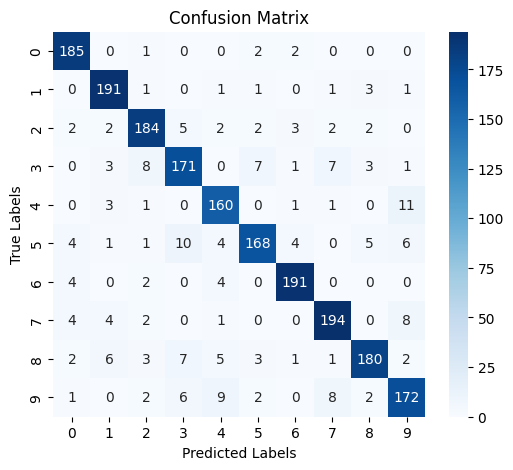

In [480]:
logistic_eval = evaluate_multiclass(y_test_pca, y_pred_multi, class_names)

In [74]:
w_b_0 = train_class_classifier(X_train_pca, y_train_pca, 0, 0.01, 1000)
pred_class_0 = class_classifier_predict(X_test_pca, w_b_0[0], w_b_0[1])
true_label_0 = [1 if i == 0 else 0 for i in y_test_pca]
print(pred_class_0)
print(true_label_0)
print(accuracy_score(true_label_0, pred_class_0))
print(precision(0,true_label_0, pred_class_0))
print(recall(0,true_label_0, pred_class_0))
print(FPR(true_label_0, pred_class_0))

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 